# 🍌 Banana Ripeness Predictor: Code Notebook

**Project by:** Hargun Preet Singh, Adarsh Kumar, Rounak Dagar, Kanishk Sakarwar

**Course:** Introduction to Machine Learning - IT3002

This notebook contains the complete code for our project. It is organized into five parts:

1.  **Project Setup:** Installs libraries and imports all dependencies.
2.  **Core Logic:** Defines the final 4-feature extractor function.
3.  **Step 1: Data Acquisition:** An interactive script to upload your 66 "cutout" images, extract features, and save them to `banana_analysis_results.xlsx`.
4.  **Step 2: Model "Bake-Off":** Loads the Excel file and runs a 5-fold cross-validation on all 6 models to find the "champion."
5.  **Step 3: Final App:** Trains the champion model (Linear Regression) on 100% of the data, saves it as `banana_model.joblib`, and launches an interactive app to predict the ripeness of new images.

---
### **Cell 1: Project Setup (Code)**
This cell installs the `openpyxl` library (for reading/writing Excel files) and imports all necessary packages for the entire notebook.

In [2]:
# --- 0. Setup ---
# Install library for reading/writing Excel files
!pip install -q openpyxl

# --- Python & ML Libraries ---
import pandas as pd
import numpy as np
import sys
import os
import io
import joblib
import cv2
import re

# --- Imports for Colab ---
# We use these for uploading files and displaying images
try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
except ImportError:
    print("Warning: Not running in Colab. File I/O will not be interactive.")
    pass

# --- Imports for Model Evaluation ---
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

print("✅ Setup complete. All libraries imported.")

✅ Setup complete. All libraries imported.


### **Cell 2: Core Logic - The 4-Feature Extractor**
This is the core of our project. Based on the analysis in our report, we discarded 5 of the 9 features and built our final model on this "Balanced Set" of 4 features.

In [3]:
def extract_banana_features(image_path):
    """
    Loads a "cutout" image (banana on a white background)
    and extracts the 4 "Golden" features:
    1. Hue_Mean
    2. Sat_StdDev
    3. Brown_Percentage
    4. Laplacian_Variance
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"    Error: Could not read image {image_path}")
        return None

    # Convert to BGR (OpenCV default) to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the banana mask by finding all pixels that are NOT pure white
    _ , banana_mask = cv2.threshold(gray_image, 250, 255, cv2.THRESH_BINARY_INV)

    total_banana_pixels = cv2.countNonZero(banana_mask)

    if total_banana_pixels < 1000: # Failsafe
        print(f"    Warning: No banana pixels found in {image_path}. Is the background pure white?")
        return None

    # --- Calculate Features (The "X" values) ---

    # Get all hue/saturation channels *only* on the banana mask
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]

    banana_hues = hue_channel[banana_mask > 0]
    banana_sats = sat_channel[banana_mask > 0]

    features = {}

    # Feature 1: Hue_Mean (Main color)
    features['Hue_Mean'] = np.mean(banana_hues)

    # Feature 2: Sat_StdDev (Color variability/spottiness)
    features['Sat_StdDev'] = np.std(banana_sats)

    # Feature 3: Brown_Percentage (Direct decay)
    # HSV ranges: H: 0-179, S: 0-255, V: 0-255
    lower_brown = np.array([5, 40, 30])
    upper_brown = np.array([25, 200, 130])
    brown_mask = cv2.inRange(hsv_image, lower_brown, upper_brown)
    banana_brown_mask = cv2.bitwise_and(brown_mask, banana_mask)
    brown_pixel_count = cv2.countNonZero(banana_brown_mask)
    features['Brown_Percentage'] = (brown_pixel_count / total_banana_pixels) * 100

    # Feature 4: Laplacian_Variance (Texture/Wrinkles)
    gray_banana = cv2.bitwise_and(gray_image, gray_image, mask=banana_mask)
    features['Laplacian_Variance'] = cv2.Laplacian(gray_banana, cv2.CV_64F).var()

    return features

print("✅ Feature Extractor function defined.")

✅ Feature Extractor function defined.


### **Cell 3: [Step 1] Data Acquisition - Create Dataset**
Run this cell. It will prompt you to **upload all 66 of your "cutout" images**. It will then process each one, extract the 4 features, and save the complete dataset to `banana_analysis_results.xlsx`.

In [4]:
def analyze_uploaded_images(output_excel_file="banana_analysis_results.xlsx"):
    """
    Prompts the user to upload images, saves them temporarily,
    extracts features, and saves results to an Excel file.
    """

    print("Please upload all 66 of your banana 'cutout' images...")
    print("You can select multiple files in the dialog box.")

    try:
        # Use Colab's file uploader
        uploaded = files.upload()
    except Exception as e:
        print(f"An error occurred during upload: {e}")
        return

    if not uploaded:
        print("No files were uploaded. Exiting.")
        return

    print(f"\nSuccessfully uploaded {len(uploaded)} file(s).")

    # Regex to parse: B<id><side>-<days_left>
    filename_pattern = re.compile(r"B(\d+)([FB])-(\d+)\.(jpeg|jpg|png)", re.IGNORECASE)

    dataset = []

    print("--- Processing all uploaded images ---")

    # Loop through each uploaded file
    for filename, content in uploaded.items():

        # Define a temporary path to save the file
        temp_image_path = f"./{filename}"

        try:
            # Write the uploaded bytes to a file so cv2.imread can read it
            with open(temp_image_path, 'wb') as f:
                f.write(content)

            print(f"Processing: {filename}")

            # --- Parse filename ---
            match = filename_pattern.match(filename)
            if match:
                days_left = int(match.group(3))
            else:
                print(f"    Warning: Could not parse metadata from filename '{filename}'.")
                days_left = 'N/A'

            # --- Extract features ---
            features = extract_banana_features(temp_image_path)

            if features:
                # Add all data to our row
                features['Filename'] = filename
                features['Days_Left'] = days_left
                dataset.append(features)
                print(f"    Successfully extracted features.")
            else:
                print(f"    Failed to extract features from {filename}.")

        except Exception as e:
            print(f"    An unexpected error occurred while processing {filename}: {e}")

        finally:
            # Clean up the temporary file
            if os.path.exists(temp_image_path):
                os.remove(temp_image_path)

    if not dataset:
        print("\nNo features were extracted from any of the uploaded images.")
        return

    # --- Convert to DataFrame and Save ---

    # Convert list of dictionaries to a DataFrame
    df = pd.DataFrame(dataset)

    # Reorder columns for clarity
    columns = ['Filename', 'Days_Left', 'Hue_Mean', 'Sat_StdDev', 'Brown_Percentage', 'Laplacian_Variance']
    df = df[columns]

    try:
        # Save to an Excel file
        df.to_excel(output_excel_file, index=False, engine='openpyxl')

        print(f"\n--- SUCCESS ---")
        print(f"Analysis complete for {len(df)} image(s).")
        print(f"Results saved to {output_excel_file}")

        print("\nDataFrame Head:")
        pd.set_option('display.float_format', lambda x: '%.2f' % x)
        print(df.head())

    except Exception as e:
        print(f"\nAn error occurred while saving the file: {e}")

# --- Run the Data Acquisition Script ---
analyze_uploaded_images()

Please upload all 66 of your banana 'cutout' images...
You can select multiple files in the dialog box.


Saving B5B-0.jpeg to B5B-0.jpeg
Saving B5F-0.jpeg to B5F-0.jpeg
Saving B4B-0.jpeg to B4B-0.jpeg
Saving B4F-0.jpeg to B4F-0.jpeg
Saving B3B-1.jpeg to B3B-1.jpeg
Saving B3F-1.jpeg to B3F-1.jpeg
Saving B2B-2.jpeg to B2B-2.jpeg
Saving B2F-2.jpeg to B2F-2.jpeg
Saving B1B-1.jpeg to B1B-1.jpeg
Saving B1F-1.jpeg to B1F-1.jpeg
Saving B7B-2.jpeg to B7B-2.jpeg
Saving B7F-2.jpeg to B7F-2.jpeg
Saving B6B-0.jpeg to B6B-0.jpeg
Saving B6F-0.jpeg to B6F-0.jpeg
Saving B5B-1.jpeg to B5B-1.jpeg
Saving B5F-1.jpeg to B5F-1.jpeg
Saving B4B-1.jpeg to B4B-1.jpeg
Saving B4F-1.jpeg to B4F-1.jpeg
Saving B3B-2.jpeg to B3B-2.jpeg
Saving B3F-2.jpeg to B3F-2.jpeg
Saving B2B-3.jpeg to B2B-3.jpeg
Saving B2F-3.jpeg to B2F-3.jpeg
Saving B1B-2.jpeg to B1B-2.jpeg
Saving B1F-2.jpeg to B1F-2.jpeg
Saving B7B-3.jpeg to B7B-3.jpeg
Saving B7F-3.jpeg to B7F-3.jpeg
Saving B6B-1.jpeg to B6B-1.jpeg
Saving B6F-1.jpeg to B6F-1.jpeg
Saving B5B-2.jpeg to B5B-2.jpeg
Saving B5F-2.jpeg to B5F-2.jpeg
Saving B4B-2.jpeg to B4B-2.jpeg
Saving B

### **Cell 4: [Step 2] Model Evaluation - The "Bake-Off"**
This cell loads the `banana_analysis_results.xlsx` file created by the previous cell. It then runs a 5-fold cross-validation on all 6 of our candidate models and prints a clean comparison table, identical to the one in our report.

In [5]:
# --- 1. CONFIGURATION ---
DATA_FILE = "banana_analysis_results.xlsx" # The Excel file from Cell 3
FEATURE_COLUMNS = ['Hue_Mean', 'Sat_StdDev', 'Brown_Percentage', 'Laplacian_Variance']
TARGET_COLUMN = 'Days_Left'
RANDOM_SEED = 42
# -------------------------

def load_data(filepath):
    """
    Loads the dataset from the specified Excel file.
    """
    print(f"Attempting to load dataset: {filepath}")
    try:
        df = pd.read_excel(filepath)
    except FileNotFoundError:
        print(f"ERROR: '{filepath}' not found.")
        print("Please run Cell 3 first to create the file.")
        return None, None

    # Drop any rows where 'Days_Left' could not be parsed
    df = df[pd.to_numeric(df[TARGET_COLUMN], errors='coerce').notnull()]
    df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(int)

    X = df[FEATURE_COLUMNS]
    y = df[TARGET_COLUMN]

    print(f"Data loaded successfully. Found {len(y)} valid samples.")
    return X, y

def get_models(random_seed=42):
    """Defines all 6 models for the bake-off."""
    models = {}
    models['Linear Regression'] = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    models['Polynomial (Deg 3)'] = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('regressor', LinearRegression())
    ])

    models['k-Nearest Neighbors (k=5)'] = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ])

    models['Support Vector (SVR)'] = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf'))
    ])

    # No scaler needed for tree-based models
    models['Random Forest'] = Pipeline([
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=random_seed, n_jobs=-1))
    ])

    models['Gradient Boosting'] = Pipeline([
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=random_seed))
    ])

    return models

def evaluate_models(X, y, models, random_seed=42):
    """
    Performs 5-fold cross-validation on all models.
    """
    n_samples = len(y)
    n_splits = 5

    if n_samples < 10: # Failsafe
        print("Not enough data to run 5-fold cross-validation.")
        return None

    cv_strategy = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    print(f"\nRunning {n_splits}-fold cross-validation on {n_samples} samples...")

    scoring_metrics = {
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'r2': 'r2'
    }

    results_list = []

    for model_name, model_pipeline in models.items():
        print(f"  Evaluating: {model_name}...")
        try:
            cv_scores = cross_validate(
                model_pipeline, X, y, cv=cv_strategy,
                scoring=scoring_metrics, n_jobs=-1
            )
            results_list.append({
                'Model': model_name,
                'Mean MAE': -cv_scores['test_mae'].mean(),
                'Mean RMSE': -cv_scores['test_rmse'].mean(),
                'Mean R-squared': cv_scores['test_r2'].mean()
            })
        except ValueError as e:
            print(f"  Could not evaluate {model_name}. Error: {e}")

    print("...Evaluation complete.")

    if not results_list:
        return None

    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values(by='Mean MAE', ascending=True)
    return results_df

# --- Run the Model Evaluation Script ---
X_data, y_data = load_data(DATA_FILE)

if X_data is not None and y_data is not None:
    all_models = get_models(random_seed=RANDOM_SEED)
    results_table = evaluate_models(X_data, y_data, all_models, random_seed=RANDOM_SEED)

    if results_table is not None:
        print("\n--- MODEL COMPARISON RESULTS ---")
        print("(Lower MAE/RMSE is better, Higher R-squared is better)")
        pd.set_option('display.float_format', lambda x: '%.4f' % x)
        print(results_table.to_string(index=False))
else:
    print("Data loading failed. Exiting.")

Attempting to load dataset: banana_analysis_results.xlsx
Data loaded successfully. Found 66 valid samples.

Running 5-fold cross-validation on 66 samples...
  Evaluating: Linear Regression...
  Evaluating: Polynomial (Deg 3)...
  Evaluating: k-Nearest Neighbors (k=5)...
  Evaluating: Support Vector (SVR)...
  Evaluating: Random Forest...
  Evaluating: Gradient Boosting...
...Evaluation complete.

--- MODEL COMPARISON RESULTS ---
(Lower MAE/RMSE is better, Higher R-squared is better)
                    Model  Mean MAE  Mean RMSE  Mean R-squared
        Linear Regression    0.7015     0.9233          0.6288
     Support Vector (SVR)    0.7700     0.9463          0.6093
k-Nearest Neighbors (k=5)    0.8095     0.9755          0.5784
            Random Forest    0.8309     1.0125          0.5616
        Gradient Boosting    0.8570     1.0697          0.5168
       Polynomial (Deg 3)    2.1566     3.4026         -4.6013


### **Cell 5: [Step 3] Final Model & Interactive Predictor**
This is the final application. This cell:
1.  Loads the dataset from `banana_analysis_results.xlsx`.
2.  Trains our "champion" model, **Linear Regression**, on 100% of the data.
3.  Saves the trained model to `banana_model.joblib`.
4.  Launches an interactive app that will ask you to upload a *new* image, predict its ripeness, and show you the results.

--- [Step 3] Launching Final Application ---
Attempting to load dataset: banana_analysis_results.xlsx
Data loaded successfully. Found 66 valid samples.
Training 'Linear Regression' on all 66 data samples...
...Training complete.
SUCCESS! Final model saved as 'banana_model.joblib'

--- 🍌 Banana Predictor App (Model: Linear Regression) ---
Type 'exit' to quit.

Please upload your 'cutout' image of a banana...


Saving WhatsApp Image 2025-11-15 at 19.23.16.jpeg to WhatsApp Image 2025-11-15 at 19.23.16.jpeg

Original Image:


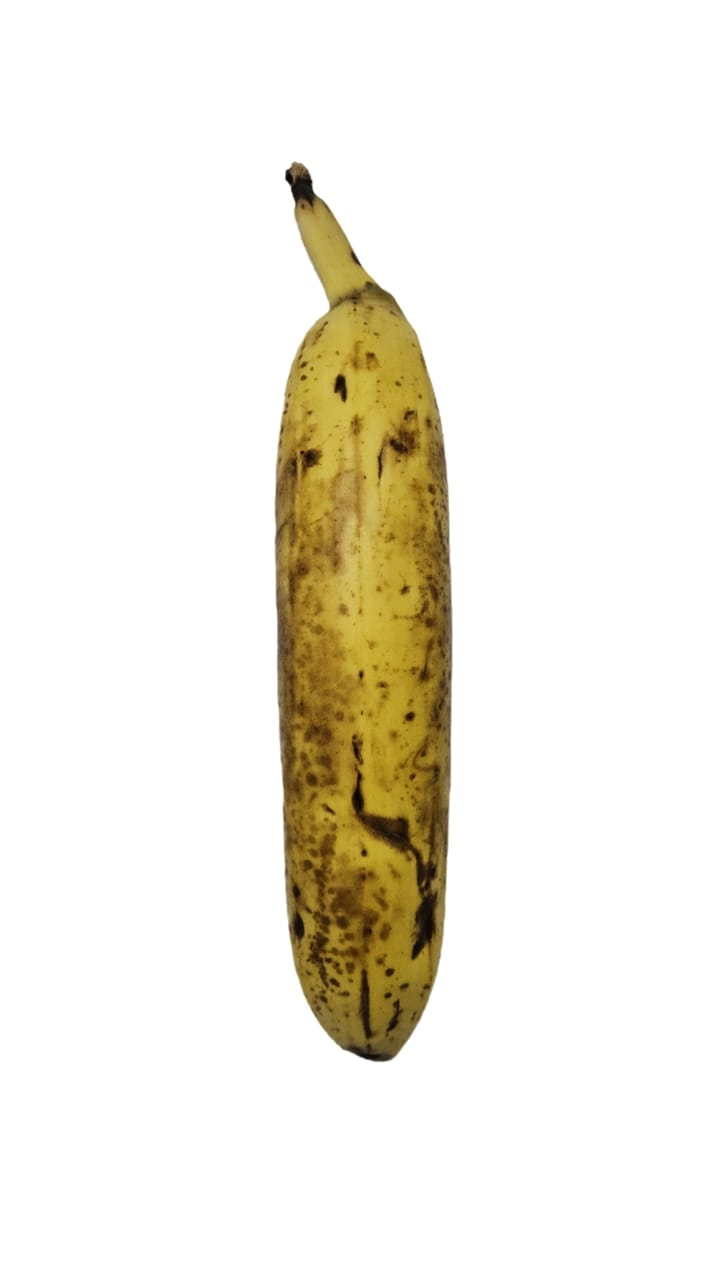

Processing 'WhatsApp Image 2025-11-15 at 19.23.16.jpeg'...

--- PREDICTION ---
Extracted Features:
  - Hue_Mean: 21.65
  - Sat_StdDev: 40.04
  - Brown_Percentage: 14.10
  - Laplacian_Variance: 531.79

Verdict: RIPE (Ready to eat)
Predicted Days Left: 1.47
--------------------


Please upload your 'cutout' image of a banana...


Press Enter to upload, or type 'exit' to quit: exit
Exiting application.


In [6]:
# --- 1. CONFIGURATION ---
DATA_FILE = "banana_analysis_results.xlsx"
FEATURE_COLUMNS = ['Hue_Mean', 'Sat_StdDev', 'Brown_Percentage', 'Laplacian_Variance']
TARGET_COLUMN = 'Days_Left'
MODEL_FILENAME = 'banana_model.joblib'
RANDOM_SEED = 42
# -------------------------

def get_best_model_pipeline():
    """
    Returns a fresh, untrained pipeline of our champion model.
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

def launch_predictor_app(model):
    """
    Launches the interactive app loop.
    """
    print(f"\n--- 🍌 Banana Predictor App (Model: Linear Regression) ---")
    print("Type 'exit' to quit.")

    while True:
        try:
            print("\nPlease upload your 'cutout' image of a banana...")
            uploaded = files.upload()

            if not uploaded:
                test_exit = input("Press Enter to upload, or type 'exit' to quit: ")
                if test_exit.lower() == 'exit':
                    print("Exiting application.")
                    break
                continue

            # Get the first (and only) file uploaded
            filename = list(uploaded.keys())[0]
            temp_image_path = f"temp_uploaded_{filename}"

            # Write bytes to a temp file
            with open(temp_image_path, 'wb') as f:
                f.write(uploaded[filename])

            print("\nOriginal Image:")
            img_for_display = cv2.imread(temp_image_path)
            cv2_imshow(img_for_display) # Display in Colab

            print(f"Processing '{filename}'...")

            # Extract features using the function from Cell 2
            features_dict = extract_banana_features(temp_image_path)

            if features_dict is None:
                print("--- ERROR: Could not find a banana or read the image. ---")
                if os.path.exists(temp_image_path): os.remove(temp_image_path)
                continue

            # Create a DataFrame, ensuring the feature order is correct
            input_df = pd.DataFrame([features_dict])[FEATURE_COLUMNS]

            # Make the prediction
            days_left = model.predict(input_df)[0]

            print("\n--- PREDICTION ---")
            print(f"Extracted Features:")
            for col in FEATURE_COLUMNS:
                print(f"  - {col}: {features_dict.get(col, 'N/A'):.2f}")

            # Give a simple verdict
            if days_left >= 3.5:
                verdict = "UNRIPE (Fresh)"
            elif days_left >= 0.5:
                verdict = "RIPE (Ready to eat)"
            elif days_left >= -1.0:
                verdict = "OVERRIPE (Use for baking)"
            else:
                verdict = "ROTTEN (Discard)"

            print(f"\nVerdict: {verdict}")
            print(f"Predicted Days Left: {days_left:.2f}")
            print("--------------------\n")

            if os.path.exists(temp_image_path):
                os.remove(temp_image_path)

        except KeyboardInterrupt:
            print("\nExiting application.")
            break
        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            if 'temp_image_path' in locals() and os.path.exists(temp_image_path):
                os.remove(temp_image_path)

# --- Run the Final App Script ---
print("--- [Step 3] Launching Final Application ---")

# 1. Load data
X_final, y_final = load_data(DATA_FILE)

if X_final is not None and y_final is not None:
    # 2. Get the champion model
    final_model = get_best_model_pipeline()

    print(f"Training 'Linear Regression' on all {len(y_final)} data samples...")
    # 3. Train on 100% of the data
    final_model.fit(X_final, y_final)
    print("...Training complete.")

    # 4. Save the model
    joblib.dump(final_model, MODEL_FILENAME)
    print(f"SUCCESS! Final model saved as '{MODEL_FILENAME}'")

    # 5. Launch the app
    launch_predictor_app(final_model)

else:
    print("Data loading failed. Cannot train final model.")